In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

In [ ]:
df = pd.read_csv('df_M30.csv', delimiter=';')

In [ ]:
new_df = df[df['oldID'].str.contains('PM1.*1$')]

In [ ]:
new_df = new_df.loc[new_df['oldID'].str.len() == 7]

In [ ]:
new_df['KM'] = new_df["oldID"].str[3:5].astype(str) + "." + new_df["oldID"].str[5:6].astype(str)

In [ ]:
new_df = new_df[new_df['fecha'].str.contains('2015-08-04')]

In [ ]:
new_df[['KM']] = new_df.loc[:,['KM']].astype(np.float64)

In [ ]:
new_df.loc[:, 'densidad'] = new_df.loc[:, "intensidad"] / new_df.loc[:, "vmed"]

In [ ]:
new_df.dropna(subset = ['densidad'])

In [ ]:
new_df['Hora'] = new_df["fecha"].str[11:13].astype(str) + "." + new_df["fecha"].str[14:16].astype(str)
new_df[['Hora']] = new_df.loc[:,['Hora']].astype(np.float64)

In [ ]:
new_df.sort_values('Hora').reset_index(drop=True)

In [ ]:
new_df.plot.scatter(x="densidad", y="Hora")

In [ ]:
display(new_df)

In [ ]:
new_df.dtypes

In [ ]:
new_df.to_csv('df_M30_KM_dia.csv', sep=';')

# Database of one day

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

In [ ]:
# Leo el CSV y dibujo los scatter

df_un_dia = pd.read_csv('df_M30_KM_dia.csv', delimiter=';')
df_un_dia.plot.scatter(x="densidad", y="Hora")
df_un_dia.plot.scatter(x="Hora", y="KM")

In [ ]:
# Ordeno el dataframe por KM y Horas y quito las mediciones erróneas

df_prueba = df_un_dia.copy()
df_prueba = df_prueba.sort_values(by=['KM', 'Hora'])
df_prueba = df_prueba.reset_index(drop=True)
df_prueba = df_prueba[['ID', 'oldID', 'fecha', 'intensidad', 'ocupacion', 'vmed', 'periodo_integracion',
                       'KM', 'densidad', 'Hora']]
df_prueba = df_prueba[~(df_prueba['KM'] == 0.2)]
df_prueba = df_prueba[~(df_prueba['KM'] == 0.9)]
df_prueba.index = range(len(df_prueba.index))

In [ ]:
# Genero un dataframe nuevo para las interpolaciones (15 minutos -> 1 minuto)

nans = np.where(np.empty_like(np.arange(576000).reshape(57600, 10)), np.nan, np.nan)
df_new = pd.DataFrame(nans, columns=['ID','oldID','fecha','intensidad','ocupacion','vmed','periodo_integracion', 
                                     'KM', 'densidad', 'Hora'])

In [ ]:
# Asigno los valores registrados cada 15 columnas y el resto como NaN para interpolar.

j = 0
for i in df_new.index.values.astype(int):
    print("i: ", i, "j: ", j)
    if (i%15) == 0:
        df_new.loc[i] = df_prueba.values[j]
        if i != 0:
            j=j+1
    else:
        df_new.loc[[i], ['ID']] = df_prueba.loc[[j], ['ID']]
        df_new.loc[[i], ['oldID']] = df_prueba.loc[[j], ['oldID']]
        df_new.loc[[i], ['fecha']] = df_prueba.loc[[j], ['fecha']]
        df_new.loc[[i], ['periodo_integracion']] = 1
        df_new.loc[[i], ['KM']] = df_prueba.loc[[j], ['KM']]

In [ ]:
# Exporto a CSV el DataFrame

df_new.to_csv('df_M30_KM_dia_perinterpol.csv', sep=';')

# Interpolado

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [ ]:
df_new = pd.read_csv('df_M30_KM_dia_perinterpol.csv', delimiter=';')
#df_new.plot.scatter(x="Hora", y="densidad")
#df_new.plot.scatter(x="Hora", y="KM", c="vmed", colormap='viridis')

df_new = df_new.sort_values(by=['KM', 'Hora'])
df_new = df_new.reset_index(drop=True)
df_new = df_new[['ID', 'oldID', 'fecha', 'intensidad', 'ocupacion', 'vmed', 'periodo_integracion',
                       'KM', 'densidad', 'Hora']]
df_new = df_new[~(df_new['KM'] == 0.2)]
df_new = df_new[~(df_new['KM'] == 0.9)]
df_new.index = range(len(df_new.index))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df_new.KM, df_new.Hora, df_new.vmed, c=df_new.vmed, cmap='magma');

#Axes3D.scatter(xs=df_new.Hora, ys=df_new.KM, zs=df_new.vmed, zdir='z', **kwargs)

# Testing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [3]:
# Interpolo.

df = pd.read_csv('df_M30_KM_dia.csv', delimiter=',')

df = df.sort_values(by=['KM', 'Hora'])
df = df.reset_index(drop=True)
df = df[['ID', 'oldID', 'fecha', 'intensidad', 'ocupacion', 'vmed', 'periodo_integracion',
                       'KM', 'densidad', 'Hora']]
df = df[~(df['KM'] == 0.2)]
df = df[~(df['KM'] == 0.9)]
df.index = range(len(df.index))

df_good = pd.DataFrame([])

for id in np.sort(df.oldID.value_counts().keys()):
    df_aux = df.loc[df['oldID'] == id]
    # Se crea la matriz de interpolación de tamaño: filas del id obtenido * 15 minutos interpolados
    #- 14 últimos minutos del día sin medición * 10 columnas
    nans = np.where(np.empty_like(np.arange((len(df_aux.index)*15-14)*10).reshape(len(df_aux.index)*15-14, 10)), np.nan, np.nan)
    df_new = pd.DataFrame(nans, columns=['ID','oldID','fecha','intensidad','ocupacion','vmed','periodo_integracion', 
                                         'KM', 'densidad', 'Hora'])
    j = 0
    for i in df_new.index.values.astype(int):
        if (i%15) == 0:
            if i != 0:
                j=j+1
            df_new.loc[i] = df_aux.values[j]
        else:
            df_new.iloc[i, df.columns.get_loc('ID')] = df_aux.iloc[j, df.columns.get_loc('ID')]
            df_new.iloc[i, df.columns.get_loc('oldID')] = df_aux.iloc[j, df.columns.get_loc('oldID')]
            df_new.iloc[i, df.columns.get_loc('fecha')] = df_aux.iloc[j, df.columns.get_loc('fecha')]
            df_new.iloc[i, df.columns.get_loc('periodo_integracion')] = 1.0
            df_new.iloc[i, df.columns.get_loc('KM')] = df_aux.iloc[j, df.columns.get_loc('KM')]

    df_int = df_new.interpolate()
    if id == 'PM10001':
        df_good = df_int
        print("Entra1: ", id)
    else:
        df_good = df_good.append(df_int, ignore_index=True)
        print("Entra: ", id)

Entra1:  PM10001
Entra:  PM10141
Entra:  PM10211
Entra:  PM10241
Entra:  PM10341
Entra:  PM10401
Entra:  PM10441
Entra:  PM10471
Entra:  PM10501
Entra:  PM10561
Entra:  PM10901
Entra:  PM10941
Entra:  PM10981
Entra:  PM11071
Entra:  PM11101
Entra:  PM11161
Entra:  PM11201
Entra:  PM11301
Entra:  PM11981
Entra:  PM12061
Entra:  PM12121
Entra:  PM12211
Entra:  PM12241
Entra:  PM12331
Entra:  PM12391
Entra:  PM12471
Entra:  PM12571
Entra:  PM12641
Entra:  PM12721
Entra:  PM12781
Entra:  PM12851
Entra:  PM12921
Entra:  PM12961
Entra:  PM12981
Entra:  PM13011
Entra:  PM13041
Entra:  PM13101
Entra:  PM13181
Entra:  PM13211
Entra:  PM13221


In [6]:
# Exporto a CSV el DataFrame

df_good.to_csv('df_M30_KM_dia_inter_temp.csv', sep=';')

In [4]:
df_good

,ID,oldID,fecha,intensidad,ocupacion,vmed,periodo_integracion,KM,densidad,Hora
0,6639.0,PM10001,2015-08-04 00:00,848.000000,3.000000,77.000000,15.0,0.0,11.012987,0.00
1,6639.0,PM10001,2015-08-04 00:00,845.000000,3.000000,77.600000,1.0,0.0,10.901268,0.01
2,6639.0,PM10001,2015-08-04 00:00,842.000000,3.000000,78.200000,1.0,0.0,10.789550,0.02
3,6639.0,PM10001,2015-08-04 00:00,839.000000,3.000000,78.800000,1.0,0.0,10.677831,0.03
4,6639.0,PM10001,2015-08-04 00:00,836.000000,3.000000,79.400000,1.0,0.0,10.566113,0.04
5,6639.0,PM10001,2015-08-04 00:00,833.000000,3.000000,80.000000,1.0,0.0,10.454394,0.05
6,6639.0,PM10001,2015-08-04 00:00,830.000000,3.000000,80.600000,1.0,0.0,10.342676,0.06
7,6639.0,PM10001,2015-08-04 00:00,827.000000,3.000000,81.200000,1.0,0.0,10.230957,0.07
8,6639.0,PM10001,2015-08-04 00:00,824.000000,3.000000,81.800000,1.0,0.0,10.119239,0.08
9,6639.0,PM10001,2015-08-04 00:00,821.000000,3.000000,82.400000,1.0,0.0,10.007520,0.09


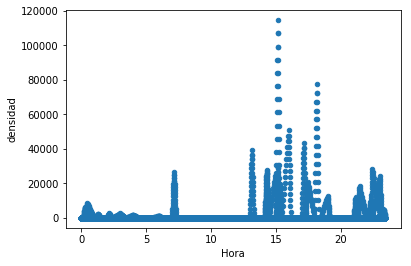

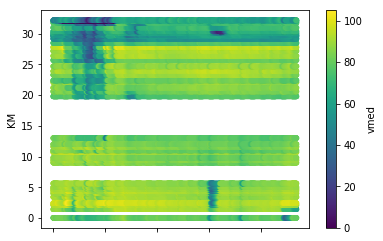

In [5]:
df_good.plot.scatter(x="Hora", y="densidad")
df_good.plot.scatter(x="Hora", y="KM", c="vmed", colormap='viridis')